In [1]:
import sys
sys.path.insert(1, '/home/georgeos/Documents/GitHub/SyMBac/') # Not needed if you installed SyMBac using pip
sys.path.insert(1, '/home/georgeos/Documents/Github/SyMBac/') # Not needed if you installed SyMBac using pip

import ray
from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
import os
import zarr
from numcodecs import Blosc
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import find_peaks
import pandas as pd

In [2]:
pad_amount = 200

radius = 150
wavelength = 0.5
NA = 1.45
n = 1.518
resize_amount = 5
pix_mic_conv = 0.065 / 3
apo_sigma = 11

PC_PSF = PSF_generator(
    radius = radius,
    wavelength = wavelength,
    NA = NA,
    n = n,
    resize_amount = resize_amount,
    pix_mic_conv = pix_mic_conv,
    apo_sigma = apo_sigma,
    mode="phase contrast",
    condenser = "Ph3",
    offset=0.00000000225
)
PC_PSF.calculate_PSF()

In [5]:
def raster_cell(length, width, separation = 0, additional_width = 0, pinching=True):
    """
    Produces a rasterised image of a cell with the intensiity of each pixel corresponding to the optical path length
    (thickness) of the cell at that point.

    :param int length: Cell length in pixels
    :param int width: Cell width in pixels
    :param int separation: An int between (0, `width`) controlling how much pinching is happening.
    :param bool pinching: Controls whether pinching is happening

    Returns
    -------

    cell : np.array
       A numpy array which contains an OPL image of the cell. Can be converted to a mask by just taking ``cell > 0``.

    """

    L = int(np.rint(length))
    W = int(np.rint(width))
    new_cell = np.zeros((L, W))
    R = (W - 1) / 2

    x_cyl = np.arange(0, 2 * R + 1, 1)
    I_cyl = np.sqrt(R ** 2 - (x_cyl - R) ** 2)
    L_cyl = L - W
    new_cell[int(W / 2):-int(W / 2), :] = I_cyl

    x_sphere = np.arange(0, int(W / 2), 1)
    sphere_Rs = np.sqrt((R) ** 2 - (x_sphere - R) ** 2)
    sphere_Rs = np.rint(sphere_Rs).astype(int)

    for c in range(len(sphere_Rs)):
        R_ = sphere_Rs[c]
        x_cyl = np.arange(0, R_, 1)
        I_cyl = np.sqrt(R_ ** 2 - (x_cyl - R_) ** 2)
        new_cell[c, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))
        new_cell[L - c - 1, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))

    if separation > 2 and pinching:
        S = int(np.rint(separation))
        new_cell[int((L - S) / 2) + 1:-int((L - S) / 2) - 1, :] = 0
        for c in range(int((S+1) / 2)):
            R__ = sphere_Rs[-c - 1]
            x_cyl_ = np.arange(0, R__, 1)
            I_cyl_ = np.sqrt(R__ ** 2 - (x_cyl_ - R__) ** 2)
            new_cell[int((L-S) / 2) + c + 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
            new_cell[-int((L-S) / 2) - c - 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
    new_cell = new_cell.astype(int)
    
        
    
    if additional_width>=1:
        additional_width = int(additional_width)
        wide_cell = np.zeros((new_cell.shape[0], int(new_cell.shape[1] + additional_width)))
        wide_cell[:,:new_cell.shape[1]//2] = new_cell[:,:new_cell.shape[1]//2]
        wide_cell[:,new_cell.shape[1]//2 + additional_width:] = new_cell[:,new_cell.shape[1]//2:]
        wide_cell[:,new_cell.shape[1]//2:new_cell.shape[1]//2 + additional_width] = np.repeat(new_cell[:,new_cell.shape[1]//2].reshape(-1,1), additional_width, axis=1)
        return wide_cell
    
    return new_cell

In [7]:
cell_lengths = (3,)
cell_widths = np.linspace(0.2, 3, 20)
additional_widths = np.linspace(0, 3, 20)
max_width = 3
tolerance = 0.1

In [9]:
cell_length = 3
cell_width = 1
additional_width = 2

In [14]:
raster_cell_length = cell_length/pix_mic_conv * resize_amount
raster_cell_width = cell_width/pix_mic_conv * resize_amount
raster_additional_width = additional_width/pix_mic_conv * resize_amount

membrane_cells = []
wavelengths = [0.45]
for wavelength in wavelengths:
    FL_PSF = PSF_generator(
            radius = radius,
            wavelength = wavelength,
            NA = NA,
            n = n,
            resize_amount = resize_amount,
            pix_mic_conv = pix_mic_conv,
            apo_sigma = apo_sigma,
            mode="3d fluo",
            condenser = "Ph3",
            z_height = 100
        )
    FL_PSF.calculate_PSF()
    FL_PSF.kernel = np.sum(FL_PSF.kernel, axis=0)
    membrane_thickness = 0.1 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, additional_width=raster_additional_width)

    pad_1 = int((cell_1.shape[0] - cell_2.shape[0])/2)
    pad_2 = int((cell_1.shape[1] - cell_2.shape[1])/2)
    cell_2 = np.pad(cell_2, ((pad_1,pad_1), (pad_2, pad_2)))
    membrane_cell = cell_1 - cell_2
    #membrane_cell = OPL_to_FL(membrane_cell, 2)
    membrane_cell = np.pad(membrane_cell, pad_amount)
    membrane_cell_conv = convolve_rescale(image=membrane_cell, kernel=FL_PSF.kernel, rescale_factor=1/resize_amount, rescale_int = True)
    #membrane_cells.append(membrane_cell_conv)
    #Image.fromarray(img_as_uint(membrane_cell_conv)).save(f"A_B_single_cells/membrane_{raster_cell_length}_{raster_cell_width}_{wavelength}.png")
#return membrane_cells


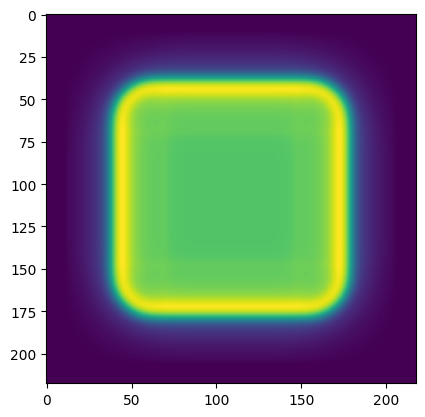

In [15]:
plt.imshow(membrane_cell_conv)